Modeling arXiv Submissions
================

The purpose of this notebook is to take a look at submissions to the [arXiv](http://www.arxiv.org). As I show below, it's very possible that the number of submissions per month will soon exceed 10000, a first in the 25-year history of the service.

To do so, I start by building a simple time-dependent model for the number of submissions each month, $S(t)$, where here $t$ indexes the number of months since the beginning of the arXiv. arXiv submission data is indexed to the beginning of each month; thus, the start 1991-07-01 is set to $t=0$, 1991-08-01 is set to $t=1$, and so on.

The tools I use to do so are pretty standard in the Python software stack:

* [`matplotlib`](http://matplotlib.org/): for plotting and visualizing data
* [`seaborn`](https://github.com/mwaskom/seaborn): to make the matplotlib plots a bit prettier
* [`pandas`](http://pandas.pydata.org/): used for wrangling data
* [`numpy`](http://www.numpy.org/): great support for scientific computation; lots of handy, miscellaneous functions


In [1]:
# Import the relevant packages
from __future__ import division

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Don't want the matplotlib plots trying
# to pop out of the screen!
%matplotlib inline

# If you just do "import seaborn",
# then seaborn messes around with the
# matplotlib backend parameters. I want
# to avoid that, so we import only the API.

import seaborn.apionly as sns

# Set the style of the plots to something aesthetic
sns.set_style('darkgrid')

# Whether to save the plots.
save = False

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Introduction
==========

With those preliminaries out of the way, we can go ahead and download the data from the arXiv. Monthly submission data is published at [this URL](http://arxiv.org/stats/get_monthly_submissions). (NOTE: This is a download link!) The `pandas.read_csv()` method supports grabbing data from URLs, so that's what I do here. (That way, I don't have to download the file each time I wanted to update my results. In fact, I could turn this entire pipeline into an automated process that, sometime in the middle of each month, goes and gets the latest submission data.)

In [2]:
# Read in the data, using the dates as the index.
df = pd.read_csv('http://arxiv.org/stats/get_monthly_submissions', index_col=0,\
                parse_dates=True)

# We don't want data from the current month, as it will be incomplete.
# So we get rid of it.

now = pd.datetime.now()
df = df[df.index < '{0}-{1}-01'.format(now.year, now.month)]

In [3]:
df.head()

,submissions,historical_delta
month,,
1991-07-01,0,-2
1991-08-01,27,-1
1991-09-01,58,0
1991-10-01,76,0
1991-11-01,64,0


As noted on the [usage statistics page for this data](http://arxiv.org/stats/monthly_submissions), there were some "submissions" which were not actually submissions per se, but were instead articles which were "migrated to the arXiv". As such, the true number of submissions each month is actually the sum of ``submissions`` and ``historical_delta``, whcih I call ``adjusted_submissions``.

In [4]:
df['adjusted_submissions'] = df.ix[:, 'submissions'] + df.ix[:, 'historical_delta']

Let's make a basic time series plot of this quantity, just to get our heads around the data.

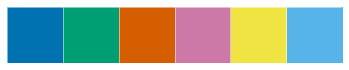

In [5]:
colors = sns.color_palette('colorblind')
sns.palplot(colors)

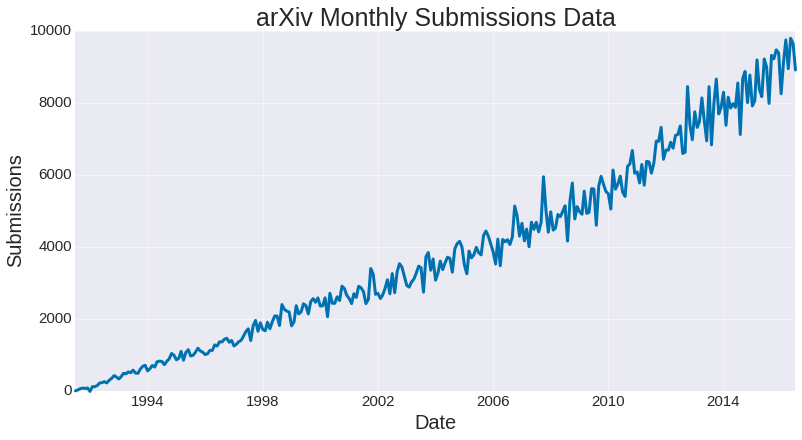

In [6]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])

Y = df['adjusted_submissions'].values
X = df.index
ax.plot(X, Y, lw=3, color=colors[0], clip_on=False)

ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Submissions', fontsize=20)
ax.set_title('arXiv Monthly Submissions Data', fontsize=25)
# Does chop off the first data point, which has -2 adjusted submissions
ax.set_ylim([0, max(ax.get_ylim())])

for s in ['x', 'y']:
    ax.tick_params(axis=s, labelsize=15)
plt.show()

if save: fig.savefig('m_submissions.svg', format='svg', bbox_inches='tight')

As we can see, there has been steady and robust growth in submissions to the arXiv. What's the maximum number of submissions in any month?

In [7]:
df[df['adjusted_submissions'] == max(df['adjusted_submissions'])].ix[:, 'adjusted_submissions']

month
2016-05-01    9792
Name: adjusted_submissions, dtype: int64

Wow! We're almost up to 10K submissions! Part of the reason I was interested in this data was to find a way to model the number of submissions, and predict when it will cross the 10K threshold.

Simple Regression Model
=================

To build a simple regression model, I start by smoothing the data. This is mostly because I wanted to remove any spurious/random fluctuations as best I could, without cherry-picking for outliers.

To do the smoothing, I used the ``pandas.rolling_mean()`` function, which takes as input a set of data and computes the rolling mean. (This is the same as the "moving average" you might see in plots of the stock market.) After playing with how many months I smoothed over, I settled on 3 as a good choice.

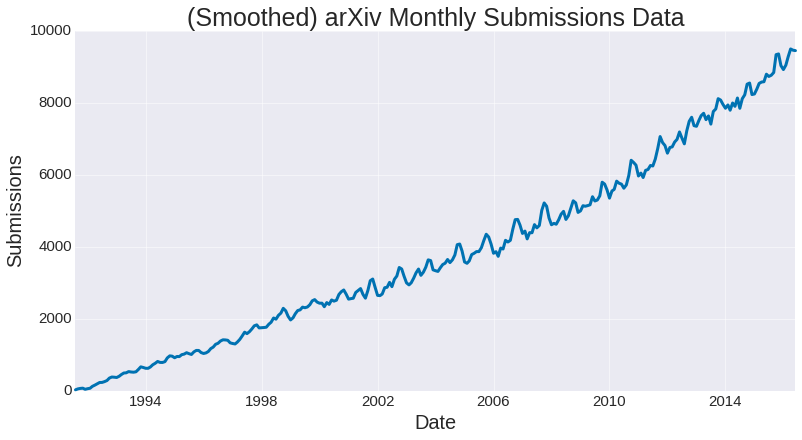

In [8]:
smoothed_df = pd.rolling_mean(df['adjusted_submissions'], 3, center=True)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])

Y = smoothed_df[~np.isnan(smoothed_df)].values
X = smoothed_df[~np.isnan(smoothed_df)].index
ax.plot(X, Y, lw=3, color=colors[0], clip_on=False)

ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Submissions', fontsize=20)
ax.set_title('(Smoothed) arXiv Monthly Submissions Data', fontsize=25)

for s in ['x', 'y']:
    ax.tick_params(axis=s, labelsize=15)
plt.show()
if save: fig.savefig('m_submissions_smooth.svg', format='svg', bbox_inches='tight')

If you squint at this data, it should become apparent that the number of submissions appears to grow quadratically in the number of months since the start. I'm not going to do any kind of rigorous model selection here; instead, we'll simply make a fit and see how well it does. That fit will be denoted as $\hat{f}$.

At this point, it should be noted that to do any kind of regression on data requires several assumptions. Since we are doing a linear regression (i.e, curve fitting), one useful assumption is that, if the true function describing the data is $f(t)$, that our observations at each time step $t_{j}$ are $S(t) = f(t_{j}) + \epsilon$, where $\epsilon$ is a normally-distributed random variable with mean 0. We're going to check this assumption later, once we've done the fit, by looking at the differences $\hat{f}(t_{j}) - S(t_{j})$, and seeing their distribution is.

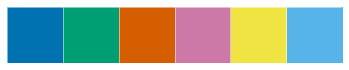

In [9]:
colors = sns.color_palette('colorblind')
sns.palplot(colors)

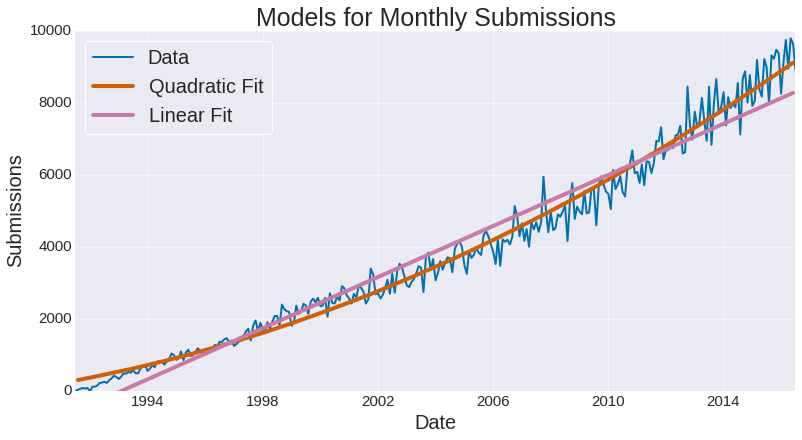

In [10]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])

Y = df[~np.isnan(df)]['adjusted_submissions'].values
X = df[~np.isnan(df)].index
ax.plot(X, Y, lw=2, label='Data', color=colors[0])

Y = smoothed_df[~np.isnan(smoothed_df)].values
X = smoothed_df[~np.isnan(smoothed_df)].index

fit = np.polyfit(range(len(X)), Y, 2)
Z = np.polyval(fit, range(len(X)))

ax.plot(X, Z, lw=4, label='Quadratic Fit', color=colors[2], ls='-')

fit2 = np.polyfit(range(len(X)), Y, 1)
Z2 = np.polyval(fit2, range(len(X)))
ax.plot(X, Z2, lw=4, label='Linear Fit', color=colors[3])

ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Submissions', fontsize=20)
ax.set_title('Models for Monthly Submissions', fontsize=25)
for s in ['x', 'y']:
    ax.tick_params(axis=s, labelsize=15)
ax.set_ylim([0, max(ax.get_ylim())])
ax.legend(loc=0, fontsize=20, frameon=True, fancybox=True)    
plt.show()
if save: fig.savefig('fit.svg', format='svg', bbox_inches='tight')

In [11]:
print('quadratic fit =  {0} t**2 + {1} t + {2}'.format(fit[0], fit[1], fit[2]))

quadratic fit =  0.056895456829 t**2 + 12.625636458 t + 300.359376438


The quadratic fit does a pretty good job, and the linear fit is pretty bad.


Now, what about the residuals? If they are not normally distributed, then this methodology might be flawed.

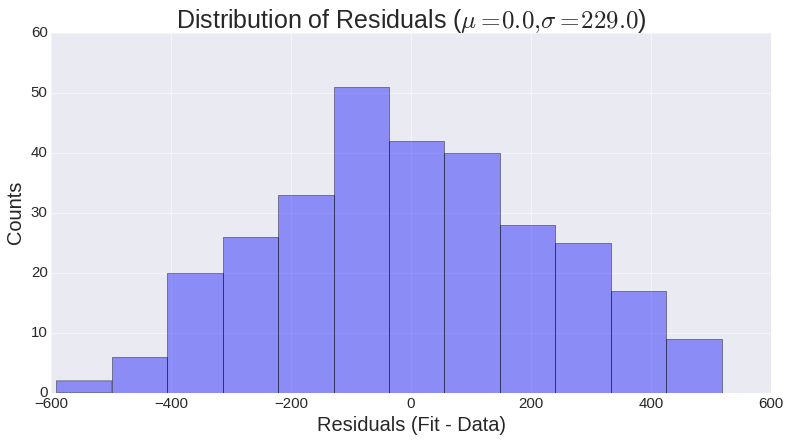

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
diff = Z - Y
sns.distplot(diff, ax=ax, kde=False)
std = np.std(diff)
for s in ['x', 'y']:
    ax.tick_params(axis=s, labelsize=15)
    
ax.set_title(r'Distribution of Residuals ($\mu = {0}, \sigma = {1}$)'.format(np.round(np.mean(diff), 5),\
                                                          np.round(std)), fontsize=25)
ax.set_xlabel('Residuals (Fit - Data)', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)

if save: fig.savefig('errors.svg', format='svg', bbox_inches='tight')

That kind of looks Gaussian, doesn't it?

The point of this calculation is to 

* enable us to justify our fitting methodology - if the distribution of residuals was not Gaussian, we're probably doing something wrong
* enable us to build a slightly sophisticated prediction method, which relies on this distribution.

At this point, I think we are ready to try and predict when the arXiv will see 10000 submissions in one month. In the next section, I present two ways of doing so.

Predicting 10K Submissions - Naive Approach
=================


With our simple model developed above, let's see if we can make a sensible prediction as to when the arXiv will see 10K submissions in one month. Recall our simple model says that the number of submissions $t$ months after 1991/07/01 is

$$\hat{f}(t) = 0.057t^{2}+ 12.63t + 300.36$$

To do prediction, we need some timesteps into the future! I use the `pandas.date_range()` function to create a list of one-month spaced dates starting from 1991/07/01, and continuing to 2018/01/01. Why that particular choice of end date? From our plot above, I think we can successfully argue that we will hit 10K submissions sooner, rather than later.

Let's see what we get if we simply compute $\hat{f}(t)$ into the future.

In [13]:
# Pandas apparently generates datetimes for the *end* of the 
# month. To get around this, we back up one month, generate
# the dates, and then add one day to each of them.
# This rolls us forward (i.e., 1991-06-31 -> 1991-07-01)
# and gives us "first-day" indexed months.
Dates = pd.date_range(start='1991-06-01', end='01-01-2018', freq='M')
Dates = Dates + np.timedelta64(1,'D')

# Do the fit
Z = np.polyval(fit, range(len(Dates)))

# For simplicity, I zoom in to dates in the
# near past/future
indices = [Dates > '05-01-2016'][0]

# Slice the data on those indices
Dates = Dates[indices]
Z = Z[indices]

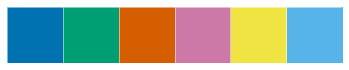

In [14]:
colors = sns.color_palette('colorblind')
sns.palplot(colors)

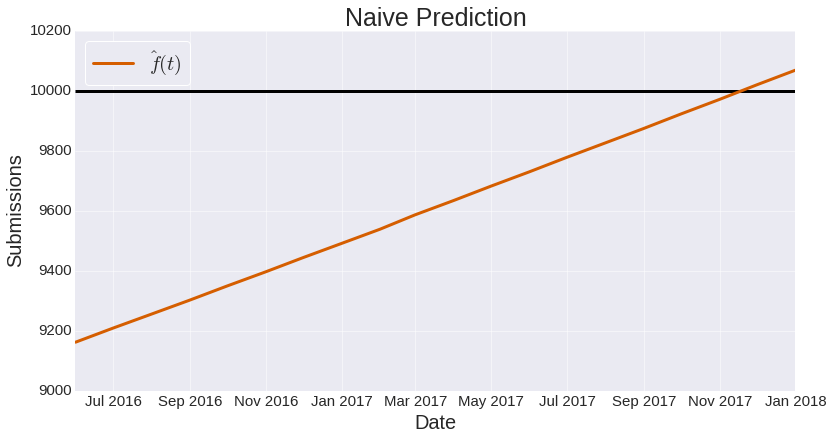

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])


ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Submissions', fontsize=20)
ax.set_title('Naive Prediction', fontsize=25)

ax.plot(Dates, Z, lw=3, label=r'$\hat{f}(t)$', color=colors[2]) 
ax.hlines(10000, min(ax.get_xlim()), max(ax.get_xlim()), lw=3)
ax.legend(loc=0, frameon=True, fancybox=True, fontsize=20)
for s in ['x', 'y']:
    ax.tick_params(axis=s, labelsize=15)

plt.show()
if save: fig.savefig('naive_predictor.svg', format='svg', bbox_inches='tight')

Identifying where $\hat{f}(t) = 10000$, we see that our simple model predicts that sometime near November 2017, the arXiv will see 10000 submissions in one month. Although satisfying (we got something sensible out of it), I don't think we will have to wait that long! Can we do better?

Predicting 10K Submissions - More Sophisticated Approach
================

One of the assumptions which went into our model was that $S(t_{j}) = f(t_{j}) + \epsilon$ (i.e., that the observed and true values can be related by a normally-distributed random variable). Could we use that information to provide us with a more sophisticated way of predicting 10K submissions?

Yes. I do so by observing that we can _simulate_ possible trajectories of the number of submissions. Suppose our (bare) prediction is $\hat{f}(t)$. If we add some random noise to that, we get an instance of one possible value that could be observed for $S(t)$.

Suppose we had $\hat{f}(t)$ values into the future, and for each, we added some $\mathcal{N}(0, \sigma^{2})$ noise, where $\sigma$ is determined by our empirical distribution of residuals. This gives us a _trajectory_ $T$. Then, we could calculate the month $M$ when we first hit 10K submissions as

$$M = \text{argmin}_{t}(T >= 10000)$$

In the parlance of random walk theory, the month $M$ is known as the [_hitting time_](https://en.wikipedia.org/wiki/Hitting_time). For each trajectory, we can calculate the hitting time, and, by computing the hitting time for many trajectories, build up a histogram of hitting times.

Let's visualize this first by making some trajectories.

In [16]:
def random_instance(Z, std):
    return Z + np.random.normal(loc=0, scale=std, size=len(Z))    

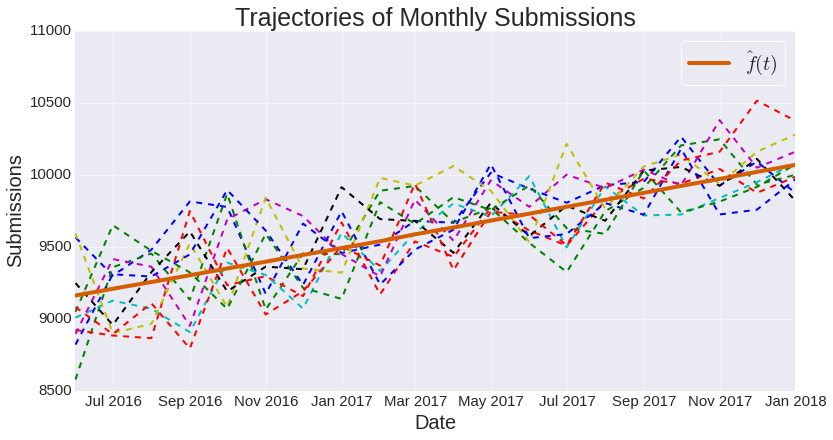

In [17]:
fig  = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
np.random.seed(0)
for j in xrange(10):
    ax.plot(Dates, random_instance(Z, std), lw=2, ls='--')

ax.plot(Dates, Z, color=colors[2], lw=4, label=r'$\hat{f}(t)$')

ax.legend(loc=0, frameon=True, fancybox=True, fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Submissions', fontsize=20)
ax.set_title('Trajectories of Monthly Submissions', fontsize=25)
for s in ['x', 'y']:
    ax.tick_params(axis=s, labelsize=15)
if save: fig.savefig('trajectories.svg', format='svg', bbox_inches='tight')

As you can see, the trajectories tend to follow our naive model $\hat{f}(t)$ (thick orange line), but there is sufficient variability as to suggest the hitting time will be well before 2017 November.

Looking at these graphs is helpful for getting a sense of what the hitting time means, and what possible values it could take. To get a more quantitative feel, I think a more algorithmic/programmatic approach is useful. Let's do the following:

* Generate many trajectories
* Calculate the hitting time for each
    * If the hitting time is in the past, we ignore that trajectory. (Essentially, ignore _counterfactual_ trajectories where we predict we've already hit 10K submissions/month.)
* Make a histogram of hitting times, and look its mean.

In [18]:
def hit_index(trajectory):
    r'''Computes the hitting time for a given trajectory.
    Since hitting time is defined as the minimum time, we
    take the minimum over all indices where the trajectory
    at that index exceeds 10000. If the trajectory
    never goes above 10000, we return NaN.'''

    indices = np.where(trajectory >= 10000)[0]
    if len(indices) > 0:
        return min(indices)
    else:
        return np.nan

In [19]:
# Generate random trajectories
N = 10000
trajectories = [random_instance(Z, std) for j in xrange(N)]

# Get the index necessary to determine whether a given trajectory
# is counterfactual (that is, it's hitting time is in the past.)
now_index = max(np.where(Dates < '{0}-{1}-01'.format(now.year, now.month))[0])

In [20]:
# Compute the indices for the trajectories
indices = [hit_index(k) for k in trajectories]

# Discard those instances which are counterfactual, or NaN
indices = [k for k in indices if (k > now_index) and (~np.isnan(k))]
num_indices = len(indices)

Once we have these hitting times, we make a histogram. Since I don't want to think in terms of "number of months since 1991/07/01", I've changed the $x$-labels to be dates of the form month/year.

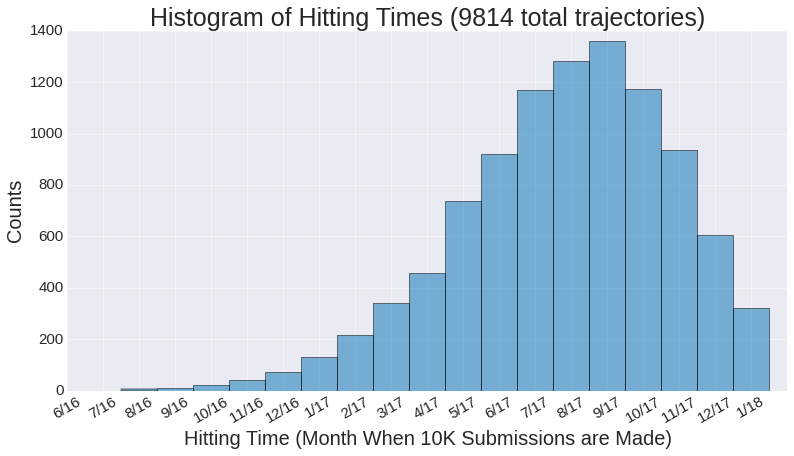

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])

# This trick from
# http://stackoverflow.com/questions/16333213/matplotlib-histograms-basic-questions
# is used to make sure the labels are in the center of the bins
bins=range(int(min(indices)), int(max(indices)) + 2, 1)
ax.hist(indices, bins=bins, align='left', alpha=.5, color=colors[0])

ax.set_xticks(range(len(Dates)))
ax.set_xticklabels(['{0}/{1}'.format(Dates[k].month, str(Dates[k].year)[-2:]) for k in ax.get_xticks() if k < len(Dates)])
ax.tick_params(axis='x', labelsize=15)
for l in ax.get_xticklabels():
    l.set_rotation(30)
ax.set_title('Histogram of Hitting Times ({0} total trajectories)'.format(num_indices), fontsize=25)
ax.set_xlabel('Hitting Time (Month When 10K Submissions are Made)', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
for s in ['x', 'y']:
    ax.tick_params(axis=s, labelsize=15)
if save: fig.savefig('mc_predictions.svg', format='svg', bbox_inches='tight')

The histogram shows us that, under the assumptions of our model, we could reasonably expect to have to wait a year before we ever get 10K submissions in one month. However, it's worht noting a non-trivial number of trajectories crossed that mark around February 2017, which is only 6 months away! What's the average time we might have to wait?

In [22]:
Dates[np.ceil(np.mean(indices))]

Timestamp('2017-08-01 00:00:00', offset='MS')

Looks like a year.

Limitations of the Model
================

Admittedly, this model is rather rudimentary. As such, we shouldn't really read too much into its predictions, possibly aside from observing that they jive with an intuition that use of the arXiv will continue to grow, at least for a while, and that at some point in the near future, we will see 10K submissions in one month. Other than that, this model really cannot say anything too quantitative about that topic.

Some explicit limitations include:

* I (arbitrarily) picked a functional form for $\hat{f}(t)$. There was no (formal) model selection involved. (That was necessary to get going on this project!)
* I assumed the data could be seen as being generated from some true functional form plus Gaussian noise. (That was necessary to justify doing the least squares regression.)
* I assumed that the standard deviation of empirial distribution of errors was a good proxy for standard deviation of the noise.
* I arbitrarily picked an endpoint for the simulations (2018/01/01). In turn, this implies an assumption that by 2018 January, we will have seen 10K submissions. If I picked a farther-out end date, the histogram above would change.
* I only ran 10000 simulations of the trajectories. Even with the assumptions above, it's possible I simply didn't observe enough trajectories to get an accurate histogram. What is more, the existence of counterfactual trajectories decreases the total number used in the histogram above.

Concluding Thoughts
===============

**Based on this analysis, I think we could conclude that within a year or so, we will see more than 10K submissions in one month on the arXiv.**

A big thanks is in order to the arXiv administrators, who have made this kind of usage data available. Without them, there's no way this analysis could be done!

----
I hope this notebook was of some use to you! If you find errors or have feedback, feel free to send me an email, or open an issue in the repository which holds this notebook.


If you like content like this, you might like my [Twitter feed](https://twitter.com/Travis_Sch).